# Pre-requisites  
- download dataset.zip,  
- unzip dataset,    
- mount drive,  

In [24]:
# Package installations
from IPython.utils import io
# with io.capture_output() as captured:
#     !pip install gdown
#     # !pip install torch==1.3.1+cu100 torchvision==0.4.2+cu100 -f https://download.pytorch.org/whl/torch_stable.html
#     !pip3 install pillow==8.2.0

#     #Install neptune.ai client for monitoring the training process
#     !pip install neptune-client
#     !pip install neptune-client neptune-tensorboard
#     !pip install neptune-contrib
#     !pip install imgaug==0.2.6


In [25]:
import neptune
# from neptunecontrib.monitoring.keras import NeptuneMonitor
from IPython.utils import io
# connect run to project
NEPTUNE_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMGUxMmQ1NC00ZDU4LTQ4ZGYtOWJjOC0xYTJkYjJmYmJiZDMifQ=='
run = neptune.init(project_qualified_name='ch.kalavritinos/OAA', api_token=NEPTUNE_TOKEN)

In [26]:
# with io.capture_output() as captured:
#   from google.colab import drive 
#   drive.mount('/content/drive')
# %cd /content/drive/MyDrive/MAI/thesis/source

In [27]:
# !unzip kvasir-dataset-v2.zip

# OAA train
Imports

Change directory to OAA-PyTorch




In [28]:
from torchvision import transforms

In [29]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from tqdm import tqdm

torch.cuda.is_available()

True

In [30]:
import PIL
PIL.__version__

'8.2.0'

# PARAMETERS

In [31]:
root_dir = 'Kvasir'
data_root = '/home/charis/kul-thesis/kvasir-dataset-v2/images'   # dataset directory
train_list = 'kvasirv2/train.txt'           # list of train images
test_list = 'kvasirv2/val.txt'              # list of val images
snapshot_dir = 'checkpoints/train/exp10/'    # where to save models
att_dir = './results_kvasir/exp10/attention/'   # where to save attentions
dataset = 'kvasir'                       # dataset used


epoch = 25
lr = 0.001
batch_size = 4
input_size = 256
disp_interval = 100
num_classes = 8
num_workers = 2
weight_decay = 0.0005
decay_points = '5,10'

crop_size = 224         # for cropping images
threshold = 0.6         # for probabilities
disp_interval = 100     # display interval
resume  = False         # resume training 
global_counter = 0      
current_epoch = 0       # number of current epoch for resuming

# data.py  
for Kvasir-v2

In [32]:
IMG_FOLDER_NAME = "polyps/"
ANNOT_FOLDER_NAME = "polyps/masks"

CAT_LIST = ['dyed-lifted-polyp',
            'dyed-resection-margins',
            'esophagitis',
            'normal-cecum',
            'normal-pylorus',
            'normal-z-line', 
            'polyps',
            'ulcerative-colitis']

CAT_NAME_TO_NUM = dict(zip(CAT_LIST,range(len(CAT_LIST))))


def load_image_label_list_from_npy(img_name_list):
    cls_labels_dict = np.load('kvasirv2/cls_labels.npy', allow_pickle=True).item()
    # print(cls_labels_dict)
    return [cls_labels_dict[img_name] for img_name in img_name_list]

def get_img_path(img_name, dataset_root):
    return os.path.join(dataset_root, img_name)

def load_img_name_list(dataset_path):
    img_gt_name_list = open(dataset_path).read().splitlines()
    img_name_list = [img_gt_name.split(' ')[0][-40:-4] for img_gt_name in img_gt_name_list]
    folder_paths_list = [img_gt_name.split(' ')[0] for img_gt_name in img_gt_name_list]
    return img_name_list, folder_paths_list

def load_label_list(dataset_path):
    zero_array = np.zeros(8, dtype=np.float32)
    list_of_arrays = []
    for i in range(8):
        z = np.zeros(8, dtype=np.float32)
        z[i]=1.0
        list_of_arrays.append(z)
    #print(list_of_arrays)
    img_name_list = open(dataset_path).read().splitlines()
    label_list = [list_of_arrays[int(img_name[-1:])-1] for img_name in img_name_list]
    return label_list

class KvasirImageDataset(Dataset):
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        self.img_name_list, self.folder_paths_list = load_img_name_list(img_name_list_path)
        self.dataset_root = dataset_root
        self.transform = transform
        self.cnt_fails = 0

    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        name = self.img_name_list[idx]
        path = self.folder_paths_list[idx]
        # print(get_img_path(path, self.dataset_root))
        # try:
        img = PIL.Image.open(get_img_path(path, self.dataset_root)).convert("RGB")
        # except: 
        #   self.cnt_fails += 1
        #   print(self.cnt_fails)
        #   return name, None

        if self.transform:
            img = self.transform(img)
        return name, img

class KvasirClsDataset(KvasirImageDataset):           # inherit init from previous class
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        super().__init__(img_name_list_path, dataset_root, transform)
        self.label_list = load_image_label_list_from_npy(self.img_name_list)        # get list from .npy file
        #self.label_list = load_image_label_list_from_xml(self.img_name_list, self.dataset_root)

    def __getitem__(self, idx):
        name, img = super().__getitem__(idx)
        label = torch.from_numpy(self.label_list[idx])
        return name, img, label

class KvasirClsDatasetMSF(KvasirClsDataset):
    def __init__(self, img_name_list_path, data_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, data_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)
        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))

        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        msf_img_list = []
        for i in range(len(ms_img_list)):
            msf_img_list.append(ms_img_list[i])
            msf_img_list.append(np.flip(ms_img_list[i], -1).copy())
        return name, msf_img_list, label

class KvasirClsDatasetMS(KvasirClsDataset):
    def __init__(self, img_name_list_path, dataset_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, dataset_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)
        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))
        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        return name, ms_img_list, label

# Losses

In [33]:
# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
#         inputs = torch.sigmoid(inputs)
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
#         intersection = (inputs * targets).sum()
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
#         return 1 - dice

# class DiceBCELoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceBCELoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
#         inputs = torch.sigmoid(inputs)
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
#         intersection = (inputs * targets).sum()
#         dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         Dice_BCE = BCE + dice_loss
#         return Dice_BCE

# class IoULoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(IoULoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
#         inputs = torch.sigmoid(inputs)
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
#         #intersection is equivalent to True Positive count
#         #union is the mutually inclusive area of all labels & predictions
#         intersection = (inputs * targets).sum()
#         total = (inputs + targets).sum()
#         union = total - intersection
#         IoU = (intersection + smooth)/(union + smooth)

#         return -IoU

# class IoUBCELoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(IoUBCELoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
#         inputs = torch.sigmoid(inputs)
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
#         #intersection is equivalent to True Positive count
#         #union is the mutually inclusive area of all labels & predictions
#         intersection = (inputs * targets).sum()
#         total = (inputs + targets).sum()
#         union = total - intersection
#         IoU = - (intersection + smooth)/(union + smooth)

#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         IoU_BCE = BCE + IoU

#         return IoU_BCE

# imutils.py


In [34]:
import PIL.Image
import random
import numpy as np

"""Modified classes to include saliency maps as well
        Classes Included:
            RandomResizeLong()
            RandomCrop()
            AvgPool2d()
            RandomHorizontalFlip()
            CenterCrop()
            RescaleNearest()

        Functions included: 
            get_random_crop_box()
            crop_with_box()
            random_crop()
            HWC_to_CHW()
            crf_inference()
            bb_IOU()
            large_rect()

"""
class RandomResizeLong():
    """Resizes images from dataset using PIL to random shape between min_long and max_long"""

    def __init__(self, min_long, max_long):
        self.min_long = min_long
        self.max_long = max_long

    def __call__(self, img, sal=None):
        target_long = random.randint(self.min_long, self.max_long)
        w, h = img.size

        if w < h:
            target_shape = (int(round(w * target_long / h)), target_long)
        else:
            target_shape = (target_long, int(round(h * target_long / w)))

        img = img.resize(target_shape, resample=PIL.Image.CUBIC)
        if sal:
           sal = sal.resize(target_shape, resample=PIL.Image.CUBIC)
           return img, sal
        return img


class RandomCrop():
    """Randomly crops images"""
    def __init__(self, cropsize):
        self.cropsize = cropsize

    def __call__(self, imgarr, sal=None):
        print(np.shape(imgarr) )
        # h, w = np.shape(imgarr)                  # height, width
        w, h = img.size
        ch = min(self.cropsize, h)
        cw = min(self.cropsize, w)

        w_space = w - self.cropsize
        h_space = h - self.cropsize

        if w_space > 0:
            cont_left = 0
            img_left = random.randrange(w_space+1)
        else:
            cont_left = random.randrange(-w_space+1)
            img_left = 0

        if h_space > 0:
            cont_top = 0
            img_top = random.randrange(h_space+1)
        else:
            cont_top = random.randrange(-h_space+1)
            img_top = 0

        container = np.zeros((self.cropsize, self.cropsize, np.shape(imgarr)[-1]), np.float32)
        container[cont_top:cont_top+ch, cont_left:cont_left+cw] = \
            imgarr[img_top:img_top+ch, img_left:img_left+cw]
        if sal is not None:
            container_sal = np.zeros((self.cropsize, self.cropsize,1), np.float32)
            container_sal[cont_top:cont_top+ch, cont_left:cont_left+cw,0] = \
                sal[img_top:img_top+ch, img_left:img_left+cw]
            return container, container_sal

        return container

def get_random_crop_box(imgsize, cropsize):
    h, w = imgsize

    ch = min(cropsize, h)
    cw = min(cropsize, w)

    w_space = w - cropsize
    h_space = h - cropsize

    if w_space > 0:
        cont_left = 0
        img_left = random.randrange(w_space + 1)
    else:
        cont_left = random.randrange(-w_space + 1)
        img_left = 0

    if h_space > 0:
        cont_top = 0
        img_top = random.randrange(h_space + 1)
    else:
        cont_top = random.randrange(-h_space + 1)
        img_top = 0

    return cont_top, cont_top+ch, cont_left, cont_left+cw, img_top, img_top+ch, img_left, img_left+cw

def crop_with_box(img, box):
    if len(img.shape) == 3:
        img_cont = np.zeros((max(box[1]-box[0], box[4]-box[5]), max(box[3]-box[2], box[7]-box[6]), img.shape[-1]), dtype=img.dtype)
    else:
        img_cont = np.zeros((max(box[1] - box[0], box[4] - box[5]), max(box[3] - box[2], box[7] - box[6])), dtype=img.dtype)
    img_cont[box[0]:box[1], box[2]:box[3]] = img[box[4]:box[5], box[6]:box[7]]
    return img_cont


def random_crop(images, cropsize, fills):
    if isinstance(images[0], PIL.Image.Image):
        imgsize = images[0].size[::-1]
    else:
        imgsize = images[0].shape[:2]
    box = get_random_crop_box(imgsize, cropsize)

    new_images = []
    for img, f in zip(images, fills):

        if isinstance(img, PIL.Image.Image):
            img = img.crop((box[6], box[4], box[7], box[5]))
            cont = PIL.Image.new(img.mode, (cropsize, cropsize))
            cont.paste(img, (box[2], box[0]))
            new_images.append(cont)

        else:
            if len(img.shape) == 3:
                cont = np.ones((cropsize, cropsize, img.shape[2]), img.dtype)*f
            else:
                cont = np.ones((cropsize, cropsize), img.dtype)*f
            cont[box[0]:box[1], box[2]:box[3]] = img[box[4]:box[5], box[6]:box[7]]
            new_images.append(cont)

    return new_images


class AvgPool2d():
    """Average pooling on 2d"""
    def __init__(self, ksize):
        self.ksize = ksize

    def __call__(self, img):
        import skimage.measure

        return skimage.measure.block_reduce(img, (self.ksize, self.ksize, 1), np.mean)


class RandomHorizontalFlip():
    """Randomly mirror images"""
    def __init__(self):
        return

    def __call__(self, img, sal=None):
        if bool(random.getrandbits(1)):
            #img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            img = np.fliplr(img).copy()
            if sal:
                #sal = sal.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                sal = np.fliplr(sal).copy()
                return img, sal 
            return img
        else:
            if sal:
                return img, sal
            return img


class CenterCrop():
    """Crop images centered"""
    def __init__(self, cropsize, default_value=0):
        self.cropsize = cropsize
        self.default_value = default_value

    def __call__(self, npimg):
        h, w = npimg.shape[:2]

        ch = min(self.cropsize, h)
        cw = min(self.cropsize, w)

        sh = h - self.cropsize
        sw = w - self.cropsize

        if sw > 0:
            cont_left = 0
            img_left = int(round(sw / 2))
        else:
            cont_left = int(round(-sw / 2))
            img_left = 0

        if sh > 0:
            cont_top = 0
            img_top = int(round(sh / 2))
        else:
            cont_top = int(round(-sh / 2))
            img_top = 0

        if len(npimg.shape) == 2:
            container = np.ones((self.cropsize, self.cropsize), npimg.dtype)*self.default_value
        else:
            container = np.ones((self.cropsize, self.cropsize, npimg.shape[2]), npimg.dtype)*self.default_value

        container[cont_top:cont_top+ch, cont_left:cont_left+cw] = \
            npimg[img_top:img_top+ch, img_left:img_left+cw]

        return container


def HWC_to_CHW(tensor, sal=False):
    if sal:
        tensor = np.expand_dims(tensor, axis=0)
    else:
        tensor = np.transpose(tensor, (2, 0, 1))
    return tensor


class RescaleNearest():
    """Resize image using nearest neighmor interpolation"""
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, npimg):
        import cv2
        return cv2.resize(npimg, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)


def bb_IOU(boxA, boxB):
    """COmputes IOU based on bounding boxes (predicted and ground truth)"""
    boxA = [float(aa) for aa in boxA]
    boxB = [float(bb) for bb in boxB]

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    if xA >= xB or yA >= yB:
        return 0, 0
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    recall = interArea / float(boxAArea)
    return iou, recall

def large_rect(rect):
    """find largest rectangles"""
    large_area = 0
    target = 0
    for i in range(len(rect)):
        area = rect[i][2]*rect[i][3]
        if large_area < area:
            large_area = area
            target = i

    x = rect[target][0]
    y = rect[target][1]
    w = rect[target][2]
    h = rect[target][3]

    return x, y, w, h

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def crf_inference(img, probs, t=10, scale_factor=1, labels=21):
    import pydensecrf.densecrf as dcrf
    from pydensecrf.utils import unary_from_softmax

    h, w = img.shape[:2]
    n_labels = labels

    d = dcrf.DenseCRF2D(w, h, n_labels)

    unary = unary_from_softmax(probs)
    unary = np.ascontiguousarray(unary)
    unary = unary.reshape((n_labels,-1))
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=3/scale_factor, compat=3)
    d.addPairwiseBilateral(sxy=80/scale_factor, srgb=13, rgbim=np.copy(img), compat=10)
    Q = d.inference(t)

    return np.array(Q).reshape((n_labels, h, w))


# train.py

In [35]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [36]:
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y, self.dataset[index][2]

    def __len__(self):
        return len(self.dataset)

    def set_transform(self, transform):
        self.transform = transform

In [37]:
# from torch import nn
# class CustomNet2(nn.Module):
#     def __init__(self, num_out=8):
#         super(CustomNet, self).__init__()

#         self.resnet_model = models.resnet152(pretrained=True)
#         self.resnet_num_ftrs = self.resnet_model.fc.in_features
#         self.resnet_model.fc = nn.Linear(self.resnet_num_ftrs, num_out)
        

#     def forward(self, x):
#         resnet_out = self.resnet_model(x)

#         return resnet_out


In [38]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):     # save points during training
    """Function for saving checkpoints"""
    savepath = os.path.join(snapshot_dir, filename)
    torch.save(state, savepath)
    print(f"Model saved to {savepath}")

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']+1, checkpoint['global_counter']

# def get_model():
#     """Function for getting VGG16"""
#     model = vgg.vgg16(pretrained=True, num_classes=num_classes, att_dir=att_dir, training_epoch=epoch)
#     model = torch.nn.DataParallel(model).cuda()                         # parallel GPU training
#     param_groups = model.module.get_parameter_groups()

#     optimizer = optim.Adam([{'params': param_groups[0], 'lr': lr},
#         {'params': param_groups[1], 'lr': 4*lr},
#         {'params': param_groups[2], 'lr': 15*lr},
#         {'params': param_groups[3], 'lr': 30*lr}]
#         , lr=lr,  weight_decay=weight_decay)
#     return  model, optimizer

# def get_model_resnet():
#     """Function for getting resnet152"""
#     model = models.resnet152(pretrained=True)
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, 8)
#     model = model.to(device)
#     param_groups = model.module.get_parameter_groups()

#     optimizer = optim.SGD([{'params': param_groups[0], 'lr': lr},
#         {'params': param_groups[1], 'lr': 4*lr},
#         {'params': param_groups[2], 'lr': 15*lr},
#         {'params': param_groups[3], 'lr': 30*lr}]
#         , lr=lr,  weight_decay=weight_decay)
#     return  model, optimizer

# def prepare_model():
#     """Taken from hyper-Kvasir classification"""
#     model = models.resnet152(pretrained=True)
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, 8)
#     model = model.to(device)
    
    return model

def prepare_model_custom():
    """Function for getting ResNet152"""
    model = CustomResNet(num_classes=num_classes, att_dir=att_dir, training_epoch=epoch)
    model = torch.nn.DataParallel(model).cuda()                         # parallel GPU training
    param_groups = model.module.get_parameter_groups()

    optimizer = optim.SGD([{'params': param_groups[0], 'lr': lr},
        {'params': param_groups[1], 'lr': 4*lr},
        {'params': param_groups[2], 'lr': 15*lr},
        {'params': param_groups[3], 'lr': 30*lr}]
        , lr=lr,  weight_decay=weight_decay)
    return  model, optimizer

In [39]:
def validate(model, criterion):
    model.eval()
    corrects = 0
    total_samples = 0
    total_loss = 0.0
    with torch.no_grad():
        for idx, dat in enumerate(val_loader):
            imgs, labels, _ = dat
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            corrects += (predicted == labels).sum().item()
            total_loss += loss.item()

    print('Acc val set: %f %%' % (100 * corrects / total_samples))
    # print('Val loss: ', float(val_loss.cpu().numpy()))
    average_loss = total_loss / total_samples
    # neptune.log_metric('val_loss', average_loss)
    return average_loss

# Train

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-new/train/'
val_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-new/test/'

train_dataset = ImageFolderWithPaths(train_dir)
val_dataset = ImageFolderWithPaths(val_dir)
class_names = train_dataset.classes
num_classes = len(class_names)


In [41]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset = ImageFolder(data_root)
# class_names = dataset.classes
# num_classes = len(class_names)
# train_len = int(0.8 * len(dataset))
# val_len = len(dataset) - train_len
# train_set, val_set = torch.utils.data.random_split(dataset, [train_len, val_len])

transform = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
}

train_set = MyLazyDataset(train_dataset, transform["train"])
val_set = MyLazyDataset(val_dataset, transform["test"])

train_loader = DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    dataset=val_set, batch_size=batch_size, shuffle=False, num_workers=2
)

In [42]:
# Define parameters for training
dataset = 'kvasirv2'
# batch_size = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(len(train_loader)*batch_size)
print(STEPS_PER_EPOCH)
# num_classes = 8

epochs = 16
lr = 0.001
disp_interval = 100
weight_decay = 0.0005
decay_points = '5, 10'

7200.0


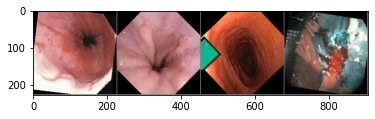

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [44]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo        # Loads the Torch serialized object at the given URL
import torch.nn.functional as F
import math
import cv2
import numpy as np
import os
from torchvision import datasets, models

In [45]:
from utils.LoadData import train_data_loader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision import datasets, models

def worker_init_fn(worker_id):
        np.random.seed(1 + worker_id)

In [47]:
# from torch import nn
# resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
# extra_convs = nn.Sequential(
#                                 nn.Conv2d(resnet_num_ftrs, 256, kernel_size=3, padding=1),
#                                 nn.ReLU(True),
#                                 nn.Conv2d(256, 256, kernel_size=3, padding=1),
#                                 nn.ReLU(True),
#                                 nn.Conv2d(256, 256, kernel_size=3, padding=1),
#                                 nn.ReLU(True),
#                                 nn.Conv2d(256, num_classes, 1)           
#                             )

In [52]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=20, init_weights=True, att_dir='./results_kvasir/exp10', training_epoch=15):
        super(CustomResNet, self).__init__()
        self.resnet_model = models.resnet50(pretrained=True)
        self.resnet_num_ftrs = self.resnet_model.fc.in_features
        self.resnet_model = torch.nn.Sequential(*(list(self.resnet_model.children())[:-1]))
        self.extra_convs = nn.Sequential(
                                nn.Conv2d(self.resnet_num_ftrs, 256, kernel_size=3, padding=1),
                                nn.ReLU(True),
                                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                nn.ReLU(True),
                                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                nn.ReLU(True),
                                nn.Conv2d(256, num_classes, 1)           
                            )
        
        self.nclasses = num_classes
        self._initialize_weights()
        self.training_epoch = training_epoch
        self.att_dir = att_dir
        if not os.path.exists(self.att_dir):
            os.makedirs(self.att_dir)
        
    def forward(self, x, epoch=1, label=None, index=None):
        x = self.resnet_model(x)
        x = self.extra_convs(x)
        
        self.map1 = x.clone().detach()
        x = F.avg_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=0)
        x = x.view(-1, self.nclasses)
        
        ###  the online attention accumulation process
        pre_probs = x.clone().detach()
        probs = torch.sigmoid(pre_probs)  # compute the prob
        pred_inds_sort = torch.argsort(-probs)

        if index != None and epoch > 0:
            atts = self.map1
            atts[atts < 0] = 0
            ind = torch.nonzero(label)
            num_labels = torch.sum(label, dim=1).long()

            for i in range(ind.shape[0]):
                batch_index, la = ind[i]
                pred_ind_select = pred_inds_sort[batch_index, :num_labels[batch_index]]

                accu_map_name = '{}/{}_{}.png'.format(self.att_dir, batch_index+index, la)
                att = atts[batch_index, la].cpu().data.numpy()
                att = att / (att.max() + 1e-8) * 255
                
                # if this is the last epoch and the image without any accumulation
                if epoch == self.training_epoch - 1 and not os.path.exists(accu_map_name):
                    cv2.imwrite(accu_map_name, att)
                    continue
                
                #naive filter out the low quality attention map with prob
                if la not in list(pred_ind_select):  
                    continue

                if not os.path.exists(accu_map_name):
                    cv2.imwrite(accu_map_name, att)
                else:
                    accu_att = cv2.imread(accu_map_name, 0)
                    accu_att = np.maximum(accu_att, att)
                    cv2.imwrite(accu_map_name,  accu_att)
         ##############################################

        return x

    def get_heatmaps(self):
        return self.map1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, 0.01)
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def get_parameter_groups(self):
        groups = ([], [], [], [])

        for name, value in self.named_parameters():

            if 'extra' in name:
                if 'weight' in name:
                    groups[2].append(value)
                else:
                    groups[3].append(value)
            else:
                if 'weight' in name:
                    groups[0].append(value)
                else:
                    groups[1].append(value)
        return groups

In [53]:
# import torch
# import torch.nn as nn
# import torch.utils.model_zoo as model_zoo        # Loads the Torch serialized object at the given URL
# import torch.nn.functional as F
# import math
# import cv2
# import numpy as np
# import os
# from torchvision import datasets, models

# class CustomNet(nn.Module):
#     def __init__(self, num_classes=8, init_weights=True, att_dir='./results_kvasir/', training_epoch=15):
#         super(CustomNet, self).__init__()

#         self.resnet_model = models.resnet50(pretrained=True)
#         self.resnet_num_ftrs = self.resnet_model.fc.in_features
#         self.resnet_model.fc = nn.Linear(self.resnet_num_ftrs, num_classes, 1)
        
#         self.nclasses = num_classes

#         self._initialize_weights()
#         self.training_epoch = training_epoch
#         self.att_dir = att_dir
#         if not os.path.exists(self.att_dir):
#             os.makedirs(self.att_dir)

#     def forward(self, x, epoch=1, label=None, index=None):
#         x = self.resnet_model(x)
#         x = self.extra_convs(x)
        
#         self.map1 = x.clone()
#         # print(type(x), x.size())
#         # print(x.size(2), x.size(3))
#         # x = F.avg_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=0)
#         x = x.view(-1, self.nclasses)
        
#         ###  the online attention accumulation process
#         pre_probs = x.clone()
#         probs = torch.sigmoid(pre_probs)  # compute the prob
        
#         if index != None and epoch > 0:
#             atts = self.map1
#             atts[atts < 0] = 0
#             ind = torch.nonzero(label)

#             for i in range(ind.shape[0]):
#                 batch_index, la = ind[i]
#                 accu_map_name = '{}{}_{}.png'.format(self.att_dir, batch_index+index, la)
#                 att = atts[batch_index, la].cpu().data.numpy()
#                 att = att / (att.max() + 1e-8) * 255
                
#                 # if this is the last epoch and the image without any accumulation
#                 if epoch == self.training_epoch - 1 and not os.path.exists(accu_map_name):
#                     cv2.imwrite(accu_map_name, att)
#                     continue
                
#                 #naive filter out the low quality attention map with prob
#                 if probs[batch_index, la] < 0.1:  
#                     continue
#                 #print(f'accu_map_name:{accu_map_name}')
#                 if att is not None:
#                     if not os.path.exists(accu_map_name):
#                         cv2.imwrite(accu_map_name, att)
#                 else:
#                     accu_att = cv2.imread(accu_map_name, 0)
#                     if att is not None:
#                         if accu_att is not None:
#                             accu_att = np.maximum(accu_att, att)
#                             cv2.imwrite(accu_map_name,  accu_att)
#          ##############################################

#         return x

#     def get_heatmaps(self):
#         return self.map1

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#                 if m.bias is not None:
#                     m.bias.data.zero_()
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 m.weight.data.normal_(0, 0.01)
#                 m.bias.data.zero_()
    
#     def get_parameter_groups(self):
#         groups = ([], [], [], [])

#         for name, value in self.named_parameters():

#             if 'extra' in name:
#                 if 'weight' in name:
#                     groups[2].append(value)
#                 else:
#                     groups[3].append(value)
#             else:
#                 if 'weight' in name:
#                     groups[0].append(value)
#                 else:
#                     groups[1].append(value)
#         return groups


# def CustomResnet50(pretrained=False, **kwargs):        # input arg: num classes
#     model = CustomResNet(**kwargs)  
#     return model


# Train the CAM network

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [64]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

############################ Args ##############################################
# data_root = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2/'
snapshot_dir = './checkpoints/train/exp10/'        # where to save models
att_dir = './results_kvasir/exp10/attention/'    # where to save attentions
dataset = 'kvasir'                                  # dataset used

lr = 0.001
input_size = 256
disp_interval = 100
num_workers = 12
threshold = 0.6         # for probabilities

resume  = False         # resume training 
global_counter = 0      
current_epoch = 0
lr_sch_factor = 0.1
lr_sch_patience = 10

In [65]:
############################ Inits #############################################
if not os.path.exists(snapshot_dir):
    os.makedirs(snapshot_dir)

# criterion = torch.nn.CrossEntropyLoss()


model, optimizer = prepare_model_custom()                      # call get_model(), get modified VGG and optimizer
criterion = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5, verbose=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DataParallel(
  (module): CustomResNet(
    (resnet_model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=Tr

In [66]:
from tqdm.notebook import trange, tqdm
global_counter = 0
best_val_loss = float('inf')
current_epoch = 0

print('Training started ...')
PARAMS = {'dataset':dataset,
            'network':'resnet50',
            'epoch_nr': epochs,
            'batch_size': batch_size,
            'optimizer': 'sgd',
            'lr': lr
      }
neptune.create_experiment('kvasirv2_train', params=PARAMS)
epochs = 40
while current_epoch < epochs:  # loop over the dataset multiple times
    model.train()
    total_loss = 0.0
    corrects = 0
    total_samples = 0
    for idx, dat in tqdm(enumerate(train_loader, 0)):
        inputs, labels, _ = dat
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        corrects += torch.sum(predicted == labels)
        total_samples += labels.size(0)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        global_counter += 1

        # print statistics
        total_loss += loss.item()
        if idx % disp_interval == disp_interval-1:    # print every X mini-batches
            print('[%d, %5d] loss: %.3f, corrects: %d/ %d' %
                  (current_epoch + 1, idx + 1, total_loss/disp_interval, corrects, total_samples))
            # neptune.log_metric('train_loss', total_loss/disp_interval)
            # neptune.log_metric('lr', optimizer.param_groups[0]['lr'])
            total_loss = 0.0
    average_accuracy = 100 * corrects / total_samples
    average_loss = total_loss / total_samples

    print(f"Training Loss: {average_loss:.6f} at epoch: {current_epoch}")
    print(f"Training Accuracy: {average_accuracy:.4f} %  at epoch: {current_epoch}")
    lr = optimizer.param_groups[0]["lr"]
    print(f"Learning rate: {lr}  at epoch: {current_epoch}")

    val_loss = validate(model, criterion)
    print("-------------------------------------------------------")
    print(f"Validation Loss: {val_loss:.6f} at epoch: {current_epoch}")
    # print(f"Validation Accuracy: {val_acc:.4f} %  at epoch: {current_epoch}")
    print(
        "-------------------------------------------------------\
        -------------------------------------------------------"
    )
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_checkpoint(
                      {'epoch': current_epoch,
                        'global_counter': global_counter,
                        'state_dict':model.state_dict(),
                        'optimizer':optimizer.state_dict()
                      },
                      filename='%s_epoch_%d.pth' %(dataset, current_epoch))
    
    if current_epoch == epochs-1:
        save_checkpoint(
                        {
                            'epoch': current_epoch,
                            'global_counter': global_counter,
                            'state_dict':model.state_dict(),
                            'optimizer':optimizer.state_dict()
                        },
                        filename='%s_epoch_%d.pth' %(dataset, current_epoch))
        
    current_epoch += 1

print('Finished Training')

Training started ...
https://app.neptune.ai/ch.kalavritinos/OAA/e/OAA-273


0it [00:00, ?it/s]

[1,   100] loss: 2.079, corrects: 53/ 400
[1,   200] loss: 2.079, corrects: 112/ 800
[1,   300] loss: 2.084, corrects: 155/ 1200
[1,   400] loss: 2.079, corrects: 213/ 1600
[1,   500] loss: 2.081, corrects: 267/ 2000
[1,   600] loss: 2.084, corrects: 307/ 2400
[1,   700] loss: 2.080, corrects: 365/ 2800
[1,   800] loss: 2.083, corrects: 408/ 3200
[1,   900] loss: 2.081, corrects: 454/ 3600
[1,  1000] loss: 2.080, corrects: 504/ 4000
[1,  1100] loss: 2.082, corrects: 553/ 4400
[1,  1200] loss: 2.081, corrects: 603/ 4800
[1,  1300] loss: 2.078, corrects: 653/ 5200
[1,  1400] loss: 2.081, corrects: 707/ 5600
[1,  1500] loss: 2.080, corrects: 759/ 6000
[1,  1600] loss: 2.080, corrects: 816/ 6400
[1,  1700] loss: 2.080, corrects: 865/ 6800
[1,  1800] loss: 2.078, corrects: 920/ 7200
Training Loss: 0.000000 at epoch: 0
Training Accuracy: 12.7778 %  at epoch: 0
Learning rate: 0.001  at epoch: 0
Acc val set: 18.000000 %
-------------------------------------------------------
Validation Loss: 0

0it [00:00, ?it/s]

[2,   100] loss: 2.068, corrects: 75/ 400
[2,   200] loss: 1.991, corrects: 144/ 800
[2,   300] loss: 1.888, corrects: 231/ 1200
[2,   400] loss: 1.879, corrects: 317/ 1600
[2,   500] loss: 1.819, corrects: 414/ 2000
[2,   600] loss: 1.812, corrects: 511/ 2400
[2,   700] loss: 1.757, corrects: 621/ 2800
[2,   800] loss: 1.808, corrects: 717/ 3200
[2,   900] loss: 1.755, corrects: 811/ 3600
[2,  1000] loss: 1.726, corrects: 916/ 4000
[2,  1100] loss: 1.756, corrects: 1023/ 4400
[2,  1200] loss: 1.657, corrects: 1114/ 4800
[2,  1300] loss: 1.665, corrects: 1221/ 5200
[2,  1400] loss: 1.689, corrects: 1329/ 5600
[2,  1500] loss: 1.645, corrects: 1425/ 6000
[2,  1600] loss: 1.654, corrects: 1523/ 6400
[2,  1700] loss: 1.638, corrects: 1631/ 6800
[2,  1800] loss: 1.640, corrects: 1745/ 7200
Training Loss: 0.000000 at epoch: 1
Training Accuracy: 24.2361 %  at epoch: 1
Learning rate: 0.001  at epoch: 1
Acc val set: 34.250000 %
-------------------------------------------------------
Validation

0it [00:00, ?it/s]

[3,   100] loss: 1.604, corrects: 112/ 400
[3,   200] loss: 1.605, corrects: 230/ 800
[3,   300] loss: 1.674, corrects: 340/ 1200
[3,   400] loss: 1.673, corrects: 438/ 1600
[3,   500] loss: 1.625, corrects: 553/ 2000
[3,   600] loss: 1.629, corrects: 675/ 2400
[3,   700] loss: 1.539, corrects: 822/ 2800
[3,   800] loss: 1.658, corrects: 953/ 3200
[3,   900] loss: 1.595, corrects: 1056/ 3600
[3,  1000] loss: 1.562, corrects: 1193/ 4000
[3,  1100] loss: 1.556, corrects: 1312/ 4400
[3,  1200] loss: 1.540, corrects: 1443/ 4800
[3,  1300] loss: 1.548, corrects: 1574/ 5200
[3,  1400] loss: 1.547, corrects: 1687/ 5600
[3,  1500] loss: 1.526, corrects: 1831/ 6000
[3,  1600] loss: 1.564, corrects: 1965/ 6400
[3,  1700] loss: 1.536, corrects: 2099/ 6800
[3,  1800] loss: 1.466, corrects: 2245/ 7200
Training Loss: 0.000000 at epoch: 2
Training Accuracy: 31.1806 %  at epoch: 2
Learning rate: 0.001  at epoch: 2
Acc val set: 39.625000 %
-------------------------------------------------------
Validat

0it [00:00, ?it/s]

[4,   100] loss: 1.467, corrects: 127/ 400
[4,   200] loss: 1.505, corrects: 258/ 800
[4,   300] loss: 1.482, corrects: 405/ 1200
[4,   400] loss: 1.414, corrects: 545/ 1600
[4,   500] loss: 1.332, corrects: 702/ 2000
[4,   600] loss: 1.499, corrects: 845/ 2400
[4,   700] loss: 1.467, corrects: 984/ 2800
[4,   800] loss: 1.307, corrects: 1141/ 3200
[4,   900] loss: 1.397, corrects: 1294/ 3600
[4,  1000] loss: 1.287, corrects: 1457/ 4000
[4,  1100] loss: 1.278, corrects: 1629/ 4400
[4,  1200] loss: 1.279, corrects: 1804/ 4800
[4,  1300] loss: 1.472, corrects: 1956/ 5200
[4,  1400] loss: 1.329, corrects: 2132/ 5600
[4,  1500] loss: 1.353, corrects: 2300/ 6000
[4,  1600] loss: 1.193, corrects: 2478/ 6400
[4,  1700] loss: 1.182, corrects: 2668/ 6800
[4,  1800] loss: 1.237, corrects: 2840/ 7200
Training Loss: 0.000000 at epoch: 3
Training Accuracy: 39.4444 %  at epoch: 3
Learning rate: 0.001  at epoch: 3
Acc val set: 41.375000 %
-------------------------------------------------------
Valida

0it [00:00, ?it/s]

[5,   100] loss: 1.259, corrects: 176/ 400
[5,   200] loss: 1.129, corrects: 362/ 800
[5,   300] loss: 1.100, corrects: 546/ 1200
[5,   400] loss: 1.184, corrects: 722/ 1600
[5,   500] loss: 0.997, corrects: 937/ 2000
[5,   600] loss: 1.073, corrects: 1139/ 2400
[5,   700] loss: 1.235, corrects: 1327/ 2800
[5,   800] loss: 1.155, corrects: 1498/ 3200
[5,   900] loss: 1.086, corrects: 1704/ 3600
[5,  1000] loss: 1.090, corrects: 1879/ 4000
[5,  1100] loss: 1.098, corrects: 2068/ 4400
[5,  1200] loss: 1.056, corrects: 2271/ 4800
[5,  1300] loss: 1.119, corrects: 2468/ 5200
[5,  1400] loss: 1.098, corrects: 2660/ 5600
[5,  1500] loss: 1.091, corrects: 2848/ 6000
[5,  1600] loss: 1.143, corrects: 3059/ 6400
[5,  1700] loss: 1.119, corrects: 3255/ 6800
[5,  1800] loss: 1.083, corrects: 3453/ 7200
Training Loss: 0.000000 at epoch: 4
Training Accuracy: 47.9583 %  at epoch: 4
Learning rate: 0.001  at epoch: 4
Acc val set: 57.875000 %
-------------------------------------------------------
Vali

0it [00:00, ?it/s]

[6,   100] loss: 1.082, corrects: 209/ 400
[6,   200] loss: 1.098, corrects: 400/ 800
[6,   300] loss: 1.023, corrects: 595/ 1200
[6,   400] loss: 1.049, corrects: 802/ 1600
[6,   500] loss: 1.011, corrects: 1015/ 2000
[6,   600] loss: 1.112, corrects: 1205/ 2400
[6,   700] loss: 1.005, corrects: 1403/ 2800
[6,   800] loss: 1.088, corrects: 1598/ 3200
[6,   900] loss: 1.014, corrects: 1799/ 3600
[6,  1000] loss: 1.065, corrects: 1991/ 4000
[6,  1100] loss: 1.006, corrects: 2190/ 4400
[6,  1200] loss: 0.994, corrects: 2398/ 4800
[6,  1300] loss: 1.023, corrects: 2612/ 5200
[6,  1400] loss: 1.067, corrects: 2814/ 5600
[6,  1500] loss: 1.052, corrects: 3021/ 6000
[6,  1600] loss: 1.022, corrects: 3226/ 6400
[6,  1700] loss: 0.986, corrects: 3429/ 6800
[6,  1800] loss: 1.027, corrects: 3623/ 7200
Training Loss: 0.000000 at epoch: 5
Training Accuracy: 50.3194 %  at epoch: 5
Learning rate: 0.001  at epoch: 5
Acc val set: 69.000000 %
-------------------------------------------------------
Val

0it [00:00, ?it/s]

[7,   100] loss: 0.994, corrects: 208/ 400
[7,   200] loss: 0.951, corrects: 410/ 800
[7,   300] loss: 1.003, corrects: 617/ 1200
[7,   400] loss: 0.957, corrects: 829/ 1600
[7,   500] loss: 1.010, corrects: 1031/ 2000
[7,   600] loss: 1.002, corrects: 1235/ 2400
[7,   700] loss: 0.997, corrects: 1435/ 2800
[7,   800] loss: 0.939, corrects: 1659/ 3200
[7,   900] loss: 0.961, corrects: 1876/ 3600
[7,  1000] loss: 0.953, corrects: 2084/ 4000
[7,  1100] loss: 1.045, corrects: 2295/ 4400
[7,  1200] loss: 0.954, corrects: 2511/ 4800
[7,  1300] loss: 0.975, corrects: 2725/ 5200
[7,  1400] loss: 1.000, corrects: 2931/ 5600
[7,  1500] loss: 0.917, corrects: 3155/ 6000
[7,  1600] loss: 1.025, corrects: 3365/ 6400
[7,  1700] loss: 0.963, corrects: 3589/ 6800
[7,  1800] loss: 0.984, corrects: 3811/ 7200
Training Loss: 0.000000 at epoch: 6
Training Accuracy: 52.9306 %  at epoch: 6
Learning rate: 0.001  at epoch: 6
Acc val set: 62.125000 %
-------------------------------------------------------
Val

0it [00:00, ?it/s]

[8,   100] loss: 0.855, corrects: 233/ 400
[8,   200] loss: 1.021, corrects: 435/ 800
[8,   300] loss: 1.021, corrects: 621/ 1200
[8,   400] loss: 0.976, corrects: 844/ 1600
[8,   500] loss: 0.916, corrects: 1065/ 2000
[8,   600] loss: 0.953, corrects: 1291/ 2400
[8,   700] loss: 0.949, corrects: 1505/ 2800
[8,   800] loss: 0.934, corrects: 1725/ 3200
[8,   900] loss: 0.968, corrects: 1941/ 3600
[8,  1000] loss: 1.002, corrects: 2152/ 4000
[8,  1100] loss: 0.890, corrects: 2383/ 4400
[8,  1200] loss: 0.973, corrects: 2603/ 4800
[8,  1300] loss: 0.922, corrects: 2833/ 5200
[8,  1400] loss: 0.915, corrects: 3069/ 5600
[8,  1500] loss: 0.888, corrects: 3299/ 6000
[8,  1600] loss: 0.900, corrects: 3515/ 6400
[8,  1700] loss: 0.819, corrects: 3756/ 6800
[8,  1800] loss: 0.931, corrects: 3968/ 7200
Training Loss: 0.000000 at epoch: 7
Training Accuracy: 55.1111 %  at epoch: 7
Learning rate: 0.001  at epoch: 7
Acc val set: 68.375000 %
-------------------------------------------------------
Val

0it [00:00, ?it/s]

[9,   100] loss: 0.884, corrects: 228/ 400
[9,   200] loss: 0.894, corrects: 450/ 800
[9,   300] loss: 0.934, corrects: 687/ 1200
[9,   400] loss: 0.962, corrects: 917/ 1600
[9,   500] loss: 0.891, corrects: 1153/ 2000
[9,   600] loss: 0.949, corrects: 1384/ 2400
[9,   700] loss: 0.897, corrects: 1620/ 2800
[9,   800] loss: 0.879, corrects: 1855/ 3200
[9,   900] loss: 0.901, corrects: 2080/ 3600
[9,  1000] loss: 0.945, corrects: 2309/ 4000
[9,  1100] loss: 0.914, corrects: 2537/ 4400
[9,  1200] loss: 0.871, corrects: 2768/ 4800
[9,  1300] loss: 0.885, corrects: 2995/ 5200
[9,  1400] loss: 0.868, corrects: 3234/ 5600
[9,  1500] loss: 0.878, corrects: 3452/ 6000
[9,  1600] loss: 0.942, corrects: 3680/ 6400
[9,  1700] loss: 1.002, corrects: 3900/ 6800
[9,  1800] loss: 0.879, corrects: 4115/ 7200
Training Loss: 0.000000 at epoch: 8
Training Accuracy: 57.1528 %  at epoch: 8
Learning rate: 0.001  at epoch: 8
Acc val set: 63.125000 %
-------------------------------------------------------
Val

0it [00:00, ?it/s]

[10,   100] loss: 1.072, corrects: 207/ 400
[10,   200] loss: 1.063, corrects: 419/ 800
[10,   300] loss: 0.923, corrects: 637/ 1200
[10,   400] loss: 0.955, corrects: 858/ 1600
[10,   500] loss: 0.998, corrects: 1074/ 2000
[10,   600] loss: 0.888, corrects: 1303/ 2400
[10,   700] loss: 0.946, corrects: 1516/ 2800
[10,   800] loss: 0.903, corrects: 1753/ 3200
[10,   900] loss: 0.930, corrects: 1979/ 3600
[10,  1000] loss: 0.857, corrects: 2204/ 4000
[10,  1100] loss: 0.870, corrects: 2435/ 4400
[10,  1200] loss: 0.914, corrects: 2650/ 4800
[10,  1300] loss: 0.830, corrects: 2890/ 5200
[10,  1400] loss: 0.959, corrects: 3115/ 5600
[10,  1500] loss: 0.960, corrects: 3345/ 6000
[10,  1600] loss: 0.951, corrects: 3572/ 6400
[10,  1700] loss: 0.896, corrects: 3812/ 6800
[10,  1800] loss: 0.876, corrects: 4038/ 7200
Training Loss: 0.000000 at epoch: 9
Training Accuracy: 56.0833 %  at epoch: 9
Learning rate: 0.001  at epoch: 9
Acc val set: 66.625000 %
-----------------------------------------

0it [00:00, ?it/s]

[11,   100] loss: 0.889, corrects: 220/ 400
[11,   200] loss: 0.863, corrects: 452/ 800
[11,   300] loss: 0.815, corrects: 690/ 1200
[11,   400] loss: 0.823, corrects: 933/ 1600
[11,   500] loss: 0.902, corrects: 1163/ 2000
[11,   600] loss: 0.819, corrects: 1404/ 2400
[11,   700] loss: 0.890, corrects: 1636/ 2800
[11,   800] loss: 0.802, corrects: 1866/ 3200
[11,   900] loss: 0.797, corrects: 2108/ 3600
[11,  1000] loss: 0.774, corrects: 2357/ 4000
[11,  1100] loss: 0.880, corrects: 2573/ 4400
[11,  1200] loss: 0.826, corrects: 2807/ 4800
[11,  1300] loss: 0.798, corrects: 3053/ 5200
[11,  1400] loss: 0.824, corrects: 3295/ 5600
[11,  1500] loss: 0.811, corrects: 3517/ 6000
[11,  1600] loss: 0.775, corrects: 3764/ 6400
[11,  1700] loss: 0.844, corrects: 4006/ 6800
[11,  1800] loss: 0.794, corrects: 4257/ 7200
Training Loss: 0.000000 at epoch: 10
Training Accuracy: 59.1250 %  at epoch: 10
Learning rate: 0.001  at epoch: 10
Acc val set: 62.625000 %
--------------------------------------

0it [00:00, ?it/s]

[12,   100] loss: 0.784, corrects: 243/ 400
[12,   200] loss: 0.786, corrects: 490/ 800
[12,   300] loss: 0.847, corrects: 739/ 1200
[12,   400] loss: 0.786, corrects: 994/ 1600
[12,   500] loss: 0.834, corrects: 1235/ 2000
[12,   600] loss: 0.827, corrects: 1485/ 2400
[12,   700] loss: 0.767, corrects: 1735/ 2800
[12,   800] loss: 0.838, corrects: 1973/ 3200
[12,   900] loss: 0.779, corrects: 2222/ 3600
[12,  1000] loss: 0.752, corrects: 2483/ 4000
[12,  1100] loss: 0.832, corrects: 2725/ 4400
[12,  1200] loss: 0.798, corrects: 2984/ 4800
[12,  1300] loss: 0.786, corrects: 3230/ 5200
[12,  1400] loss: 0.860, corrects: 3484/ 5600
[12,  1500] loss: 0.804, corrects: 3723/ 6000
[12,  1600] loss: 0.865, corrects: 3964/ 6400
[12,  1700] loss: 0.681, corrects: 4218/ 6800
[12,  1800] loss: 0.849, corrects: 4451/ 7200
Training Loss: 0.000000 at epoch: 11
Training Accuracy: 61.8194 %  at epoch: 11
Learning rate: 0.001  at epoch: 11
Acc val set: 59.500000 %
--------------------------------------

0it [00:00, ?it/s]

[13,   100] loss: 0.762, corrects: 257/ 400
[13,   200] loss: 0.800, corrects: 500/ 800
[13,   300] loss: 0.742, corrects: 765/ 1200
[13,   400] loss: 0.777, corrects: 1019/ 1600
[13,   500] loss: 0.813, corrects: 1262/ 2000
[13,   600] loss: 0.817, corrects: 1502/ 2400
[13,   700] loss: 0.788, corrects: 1741/ 2800
[13,   800] loss: 0.785, corrects: 1993/ 3200
[13,   900] loss: 0.738, corrects: 2242/ 3600
[13,  1000] loss: 0.816, corrects: 2485/ 4000
[13,  1100] loss: 0.773, corrects: 2735/ 4400
[13,  1200] loss: 0.795, corrects: 2996/ 4800
[13,  1300] loss: 0.719, corrects: 3272/ 5200
[13,  1400] loss: 0.746, corrects: 3528/ 5600
[13,  1500] loss: 0.757, corrects: 3786/ 6000
[13,  1600] loss: 0.833, corrects: 4033/ 6400
[13,  1700] loss: 0.758, corrects: 4288/ 6800
[13,  1800] loss: 0.711, corrects: 4555/ 7200
Training Loss: 0.000000 at epoch: 12
Training Accuracy: 63.2639 %  at epoch: 12
Learning rate: 0.001  at epoch: 12
Acc val set: 70.250000 %
-------------------------------------

0it [00:00, ?it/s]

[14,   100] loss: 0.776, corrects: 252/ 400
[14,   200] loss: 0.735, corrects: 512/ 800
[14,   300] loss: 0.739, corrects: 771/ 1200
[14,   400] loss: 0.806, corrects: 1021/ 1600
[14,   500] loss: 0.739, corrects: 1286/ 2000
[14,   600] loss: 0.758, corrects: 1540/ 2400
[14,   700] loss: 0.724, corrects: 1803/ 2800
[14,   800] loss: 0.793, corrects: 2069/ 3200
[14,   900] loss: 0.739, corrects: 2331/ 3600
[14,  1000] loss: 0.738, corrects: 2601/ 4000
[14,  1100] loss: 0.769, corrects: 2857/ 4400
[14,  1200] loss: 0.755, corrects: 3091/ 4800
[14,  1300] loss: 0.825, corrects: 3328/ 5200
[14,  1400] loss: 0.711, corrects: 3585/ 5600
[14,  1500] loss: 0.672, corrects: 3857/ 6000
[14,  1600] loss: 0.742, corrects: 4113/ 6400
[14,  1700] loss: 0.784, corrects: 4356/ 6800
[14,  1800] loss: 0.712, corrects: 4616/ 7200
Training Loss: 0.000000 at epoch: 13
Training Accuracy: 64.1111 %  at epoch: 13
Learning rate: 0.001  at epoch: 13
Acc val set: 66.000000 %
-------------------------------------

0it [00:00, ?it/s]

[15,   100] loss: 0.683, corrects: 273/ 400
[15,   200] loss: 0.698, corrects: 537/ 800
[15,   300] loss: 0.651, corrects: 815/ 1200
[15,   400] loss: 0.743, corrects: 1092/ 1600
[15,   500] loss: 0.748, corrects: 1349/ 2000
[15,   600] loss: 0.674, corrects: 1616/ 2400
[15,   700] loss: 0.726, corrects: 1878/ 2800
[15,   800] loss: 0.750, corrects: 2141/ 3200
[15,   900] loss: 0.708, corrects: 2392/ 3600
[15,  1000] loss: 0.727, corrects: 2651/ 4000
[15,  1100] loss: 0.755, corrects: 2909/ 4400
[15,  1200] loss: 0.768, corrects: 3157/ 4800
[15,  1300] loss: 0.767, corrects: 3405/ 5200
[15,  1400] loss: 0.702, corrects: 3662/ 5600
[15,  1500] loss: 0.680, corrects: 3921/ 6000
[15,  1600] loss: 0.675, corrects: 4189/ 6400
[15,  1700] loss: 0.726, corrects: 4458/ 6800
[15,  1800] loss: 0.770, corrects: 4707/ 7200
Training Loss: 0.000000 at epoch: 14
Training Accuracy: 65.3750 %  at epoch: 14
Learning rate: 0.001  at epoch: 14
Acc val set: 69.875000 %
-------------------------------------

0it [00:00, ?it/s]

[16,   100] loss: 0.723, corrects: 260/ 400
[16,   200] loss: 0.755, corrects: 524/ 800
[16,   300] loss: 0.725, corrects: 788/ 1200
[16,   400] loss: 0.751, corrects: 1041/ 1600
[16,   500] loss: 0.710, corrects: 1316/ 2000
[16,   600] loss: 0.673, corrects: 1591/ 2400
[16,   700] loss: 0.687, corrects: 1856/ 2800
[16,   800] loss: 0.663, corrects: 2124/ 3200
[16,   900] loss: 0.716, corrects: 2382/ 3600
[16,  1000] loss: 0.688, corrects: 2642/ 4000
[16,  1100] loss: 0.675, corrects: 2913/ 4400
[16,  1200] loss: 0.709, corrects: 3180/ 4800
[16,  1300] loss: 0.681, corrects: 3446/ 5200
[16,  1400] loss: 0.691, corrects: 3719/ 5600
[16,  1500] loss: 0.713, corrects: 3982/ 6000
[16,  1600] loss: 0.639, corrects: 4260/ 6400
[16,  1700] loss: 0.660, corrects: 4533/ 6800
[16,  1800] loss: 0.666, corrects: 4800/ 7200
Training Loss: 0.000000 at epoch: 15
Training Accuracy: 66.6667 %  at epoch: 15
Learning rate: 0.001  at epoch: 15
Acc val set: 66.875000 %
-------------------------------------

0it [00:00, ?it/s]

[17,   100] loss: 0.606, corrects: 282/ 400
[17,   200] loss: 0.687, corrects: 558/ 800
[17,   300] loss: 0.651, corrects: 832/ 1200
[17,   400] loss: 0.640, corrects: 1097/ 1600
[17,   500] loss: 0.692, corrects: 1352/ 2000
[17,   600] loss: 0.680, corrects: 1606/ 2400
[17,   700] loss: 0.689, corrects: 1865/ 2800
[17,   800] loss: 0.567, corrects: 2153/ 3200
[17,   900] loss: 0.656, corrects: 2423/ 3600
[17,  1000] loss: 0.689, corrects: 2693/ 4000
[17,  1100] loss: 0.715, corrects: 2965/ 4400
[17,  1200] loss: 0.732, corrects: 3234/ 4800
[17,  1300] loss: 0.645, corrects: 3506/ 5200
[17,  1400] loss: 0.701, corrects: 3769/ 5600
[17,  1500] loss: 0.698, corrects: 4028/ 6000
[17,  1600] loss: 0.602, corrects: 4305/ 6400
[17,  1700] loss: 0.612, corrects: 4594/ 6800
[17,  1800] loss: 0.638, corrects: 4873/ 7200
Training Loss: 0.000000 at epoch: 16
Training Accuracy: 67.6806 %  at epoch: 16
Learning rate: 0.001  at epoch: 16
Acc val set: 70.250000 %
-------------------------------------

0it [00:00, ?it/s]

[18,   100] loss: 0.639, corrects: 283/ 400
[18,   200] loss: 0.639, corrects: 569/ 800
[18,   300] loss: 0.605, corrects: 852/ 1200
[18,   400] loss: 0.646, corrects: 1123/ 1600
[18,   500] loss: 0.663, corrects: 1384/ 2000
[18,   600] loss: 0.646, corrects: 1649/ 2400
[18,   700] loss: 0.726, corrects: 1916/ 2800
[18,   800] loss: 0.631, corrects: 2203/ 3200
[18,   900] loss: 0.641, corrects: 2496/ 3600
[18,  1000] loss: 0.642, corrects: 2783/ 4000
[18,  1100] loss: 0.681, corrects: 3042/ 4400
[18,  1200] loss: 0.654, corrects: 3318/ 4800
[18,  1300] loss: 0.599, corrects: 3598/ 5200
[18,  1400] loss: 0.620, corrects: 3872/ 5600
[18,  1500] loss: 0.635, corrects: 4143/ 6000
[18,  1600] loss: 0.705, corrects: 4413/ 6400
[18,  1700] loss: 0.634, corrects: 4686/ 6800
[18,  1800] loss: 0.615, corrects: 4969/ 7200
Training Loss: 0.000000 at epoch: 17
Training Accuracy: 69.0139 %  at epoch: 17
Learning rate: 0.001  at epoch: 17
Acc val set: 70.875000 %
-------------------------------------

0it [00:00, ?it/s]

[19,   100] loss: 0.710, corrects: 264/ 400
[19,   200] loss: 0.576, corrects: 562/ 800
[19,   300] loss: 0.660, corrects: 843/ 1200
[19,   400] loss: 0.581, corrects: 1141/ 1600
[19,   500] loss: 0.626, corrects: 1420/ 2000
[19,   600] loss: 0.595, corrects: 1709/ 2400
[19,   700] loss: 0.649, corrects: 1987/ 2800
[19,   800] loss: 0.660, corrects: 2259/ 3200
[19,   900] loss: 0.612, corrects: 2545/ 3600
[19,  1000] loss: 0.634, corrects: 2836/ 4000
[19,  1100] loss: 0.539, corrects: 3136/ 4400
[19,  1200] loss: 0.620, corrects: 3421/ 4800
[19,  1300] loss: 0.591, corrects: 3713/ 5200
[19,  1400] loss: 0.612, corrects: 4010/ 5600
[19,  1500] loss: 0.698, corrects: 4271/ 6000
[19,  1600] loss: 0.604, corrects: 4544/ 6400
[19,  1700] loss: 0.576, corrects: 4839/ 6800
[19,  1800] loss: 0.588, corrects: 5138/ 7200
Training Loss: 0.000000 at epoch: 18
Training Accuracy: 71.3611 %  at epoch: 18
Learning rate: 0.001  at epoch: 18
Acc val set: 70.125000 %
-------------------------------------

0it [00:00, ?it/s]

[20,   100] loss: 0.580, corrects: 289/ 400
[20,   200] loss: 0.636, corrects: 561/ 800
[20,   300] loss: 0.609, corrects: 844/ 1200
[20,   400] loss: 0.608, corrects: 1136/ 1600
[20,   500] loss: 0.629, corrects: 1405/ 2000
[20,   600] loss: 0.630, corrects: 1683/ 2400
[20,   700] loss: 0.632, corrects: 1970/ 2800
[20,   800] loss: 0.582, corrects: 2257/ 3200
[20,   900] loss: 0.571, corrects: 2555/ 3600
[20,  1000] loss: 0.616, corrects: 2831/ 4000
[20,  1100] loss: 0.632, corrects: 3105/ 4400
[20,  1200] loss: 0.632, corrects: 3392/ 4800
[20,  1300] loss: 0.634, corrects: 3663/ 5200
[20,  1400] loss: 0.663, corrects: 3934/ 5600
[20,  1500] loss: 0.571, corrects: 4236/ 6000
[20,  1600] loss: 0.593, corrects: 4511/ 6400
[20,  1700] loss: 0.559, corrects: 4804/ 6800
[20,  1800] loss: 0.603, corrects: 5085/ 7200
Training Loss: 0.000000 at epoch: 19
Training Accuracy: 70.6250 %  at epoch: 19
Learning rate: 0.001  at epoch: 19
Acc val set: 72.125000 %
-------------------------------------

0it [00:00, ?it/s]

[21,   100] loss: 0.589, corrects: 290/ 400
[21,   200] loss: 0.628, corrects: 571/ 800
[21,   300] loss: 0.623, corrects: 852/ 1200
[21,   400] loss: 0.565, corrects: 1149/ 1600
[21,   500] loss: 0.571, corrects: 1449/ 2000
[21,   600] loss: 0.668, corrects: 1723/ 2400
[21,   700] loss: 0.615, corrects: 2005/ 2800
[21,   800] loss: 0.527, corrects: 2296/ 3200
[21,   900] loss: 0.576, corrects: 2584/ 3600
[21,  1000] loss: 0.516, corrects: 2874/ 4000
[21,  1100] loss: 0.592, corrects: 3154/ 4400
[21,  1200] loss: 0.570, corrects: 3448/ 4800
[21,  1300] loss: 0.552, corrects: 3756/ 5200
[21,  1400] loss: 0.587, corrects: 4049/ 5600
[21,  1500] loss: 0.546, corrects: 4358/ 6000
[21,  1600] loss: 0.564, corrects: 4663/ 6400
[21,  1700] loss: 0.555, corrects: 4960/ 6800
[21,  1800] loss: 0.575, corrects: 5253/ 7200
Training Loss: 0.000000 at epoch: 20
Training Accuracy: 72.9583 %  at epoch: 20
Learning rate: 0.001  at epoch: 20
Acc val set: 66.625000 %
-------------------------------------

0it [00:00, ?it/s]

[22,   100] loss: 0.615, corrects: 283/ 400
[22,   200] loss: 0.567, corrects: 593/ 800
[22,   300] loss: 0.684, corrects: 864/ 1200
[22,   400] loss: 0.524, corrects: 1154/ 1600
[22,   500] loss: 0.510, corrects: 1456/ 2000
[22,   600] loss: 0.617, corrects: 1739/ 2400
[22,   700] loss: 0.566, corrects: 2037/ 2800
[22,   800] loss: 0.556, corrects: 2335/ 3200
[22,   900] loss: 0.599, corrects: 2632/ 3600
[22,  1000] loss: 0.545, corrects: 2922/ 4000
[22,  1100] loss: 0.479, corrects: 3229/ 4400
[22,  1200] loss: 0.525, corrects: 3531/ 4800
[22,  1300] loss: 0.631, corrects: 3822/ 5200
[22,  1400] loss: 0.551, corrects: 4115/ 5600
[22,  1500] loss: 0.580, corrects: 4403/ 6000
[22,  1600] loss: 0.512, corrects: 4704/ 6400
[22,  1700] loss: 0.644, corrects: 4993/ 6800
[22,  1800] loss: 0.559, corrects: 5282/ 7200
Training Loss: 0.000000 at epoch: 21
Training Accuracy: 73.3611 %  at epoch: 21
Learning rate: 0.001  at epoch: 21
Acc val set: 76.125000 %
-------------------------------------

0it [00:00, ?it/s]

[23,   100] loss: 0.635, corrects: 288/ 400
[23,   200] loss: 0.553, corrects: 574/ 800
[23,   300] loss: 0.586, corrects: 861/ 1200
[23,   400] loss: 0.505, corrects: 1164/ 1600
[23,   500] loss: 0.526, corrects: 1466/ 2000
[23,   600] loss: 0.531, corrects: 1766/ 2400
[23,   700] loss: 0.580, corrects: 2056/ 2800
[23,   800] loss: 0.571, corrects: 2349/ 3200
[23,   900] loss: 0.521, corrects: 2646/ 3600
[23,  1000] loss: 0.572, corrects: 2930/ 4000
[23,  1100] loss: 0.540, corrects: 3235/ 4400
[23,  1200] loss: 0.546, corrects: 3532/ 4800
[23,  1300] loss: 0.511, corrects: 3835/ 5200
[23,  1400] loss: 0.576, corrects: 4119/ 5600
[23,  1500] loss: 0.613, corrects: 4399/ 6000
[23,  1600] loss: 0.516, corrects: 4705/ 6400
[23,  1700] loss: 0.524, corrects: 5009/ 6800
[23,  1800] loss: 0.521, corrects: 5310/ 7200
Training Loss: 0.000000 at epoch: 22
Training Accuracy: 73.7500 %  at epoch: 22
Learning rate: 0.001  at epoch: 22
Acc val set: 75.250000 %
-------------------------------------

0it [00:00, ?it/s]

[24,   100] loss: 0.498, corrects: 297/ 400
[24,   200] loss: 0.584, corrects: 579/ 800
[24,   300] loss: 0.519, corrects: 887/ 1200
[24,   400] loss: 0.544, corrects: 1190/ 1600
[24,   500] loss: 0.512, corrects: 1489/ 2000
[24,   600] loss: 0.595, corrects: 1776/ 2400
[24,   700] loss: 0.531, corrects: 2066/ 2800
[24,   800] loss: 0.479, corrects: 2371/ 3200
[24,   900] loss: 0.523, corrects: 2674/ 3600
[24,  1000] loss: 0.524, corrects: 2975/ 4000
[24,  1100] loss: 0.564, corrects: 3273/ 4400
[24,  1200] loss: 0.504, corrects: 3577/ 4800
[24,  1300] loss: 0.512, corrects: 3887/ 5200
[24,  1400] loss: 0.558, corrects: 4181/ 5600
[24,  1500] loss: 0.543, corrects: 4476/ 6000
[24,  1600] loss: 0.571, corrects: 4767/ 6400
[24,  1700] loss: 0.485, corrects: 5072/ 6800
[24,  1800] loss: 0.507, corrects: 5383/ 7200
Training Loss: 0.000000 at epoch: 23
Training Accuracy: 74.7639 %  at epoch: 23
Learning rate: 0.001  at epoch: 23
Acc val set: 66.625000 %
-------------------------------------

0it [00:00, ?it/s]

[25,   100] loss: 0.499, corrects: 310/ 400
[25,   200] loss: 0.523, corrects: 605/ 800
[25,   300] loss: 0.504, corrects: 902/ 1200
[25,   400] loss: 0.514, corrects: 1200/ 1600
[25,   500] loss: 0.545, corrects: 1483/ 2000
[25,   600] loss: 0.480, corrects: 1790/ 2400
[25,   700] loss: 0.543, corrects: 2096/ 2800
[25,   800] loss: 0.536, corrects: 2383/ 3200
[25,   900] loss: 0.553, corrects: 2674/ 3600
[25,  1000] loss: 0.567, corrects: 2975/ 4000
[25,  1100] loss: 0.601, corrects: 3273/ 4400
[25,  1200] loss: 0.504, corrects: 3579/ 4800
[25,  1300] loss: 0.551, corrects: 3882/ 5200
[25,  1400] loss: 0.512, corrects: 4183/ 5600
[25,  1500] loss: 0.530, corrects: 4473/ 6000
[25,  1600] loss: 0.501, corrects: 4769/ 6400
[25,  1700] loss: 0.575, corrects: 5049/ 6800
[25,  1800] loss: 0.558, corrects: 5341/ 7200
Training Loss: 0.000000 at epoch: 24
Training Accuracy: 74.1806 %  at epoch: 24
Learning rate: 0.001  at epoch: 24
Acc val set: 77.250000 %
-------------------------------------

0it [00:00, ?it/s]

[26,   100] loss: 0.537, corrects: 292/ 400
[26,   200] loss: 0.495, corrects: 589/ 800
[26,   300] loss: 0.510, corrects: 883/ 1200
[26,   400] loss: 0.560, corrects: 1170/ 1600
[26,   500] loss: 0.494, corrects: 1484/ 2000
[26,   600] loss: 0.533, corrects: 1780/ 2400
[26,   700] loss: 0.490, corrects: 2099/ 2800
[26,   800] loss: 0.546, corrects: 2392/ 3200
[26,   900] loss: 0.426, corrects: 2712/ 3600
[26,  1000] loss: 0.468, corrects: 3022/ 4000
[26,  1100] loss: 0.567, corrects: 3305/ 4400
[26,  1200] loss: 0.560, corrects: 3598/ 4800
[26,  1300] loss: 0.459, corrects: 3899/ 5200
[26,  1400] loss: 0.474, corrects: 4201/ 5600
[26,  1500] loss: 0.492, corrects: 4501/ 6000
[26,  1600] loss: 0.526, corrects: 4797/ 6400
[26,  1700] loss: 0.484, corrects: 5109/ 6800
[26,  1800] loss: 0.507, corrects: 5410/ 7200
Training Loss: 0.000000 at epoch: 25
Training Accuracy: 75.1389 %  at epoch: 25
Learning rate: 0.001  at epoch: 25
Acc val set: 67.000000 %
-------------------------------------

0it [00:00, ?it/s]

[27,   100] loss: 0.542, corrects: 302/ 400
[27,   200] loss: 0.482, corrects: 617/ 800
[27,   300] loss: 0.454, corrects: 934/ 1200
[27,   400] loss: 0.490, corrects: 1235/ 1600
[27,   500] loss: 0.434, corrects: 1553/ 2000
[27,   600] loss: 0.413, corrects: 1877/ 2400
[27,   700] loss: 0.371, corrects: 2211/ 2800
[27,   800] loss: 0.470, corrects: 2520/ 3200
[27,   900] loss: 0.441, corrects: 2825/ 3600
[27,  1000] loss: 0.440, corrects: 3139/ 4000
[27,  1100] loss: 0.486, corrects: 3449/ 4400
[27,  1200] loss: 0.466, corrects: 3766/ 4800
[27,  1300] loss: 0.397, corrects: 4084/ 5200
[27,  1400] loss: 0.386, corrects: 4404/ 5600
[27,  1500] loss: 0.425, corrects: 4727/ 6000
[27,  1600] loss: 0.437, corrects: 5045/ 6400
[27,  1700] loss: 0.501, corrects: 5348/ 6800
[27,  1800] loss: 0.465, corrects: 5663/ 7200
Training Loss: 0.000000 at epoch: 26
Training Accuracy: 78.6528 %  at epoch: 26
Learning rate: 0.0001  at epoch: 26
Acc val set: 68.125000 %
------------------------------------

0it [00:00, ?it/s]

[28,   100] loss: 0.410, corrects: 318/ 400
[28,   200] loss: 0.431, corrects: 632/ 800
[28,   300] loss: 0.428, corrects: 951/ 1200
[28,   400] loss: 0.401, corrects: 1275/ 1600
[28,   500] loss: 0.417, corrects: 1593/ 2000
[28,   600] loss: 0.415, corrects: 1914/ 2400
[28,   700] loss: 0.390, corrects: 2235/ 2800
[28,   800] loss: 0.415, corrects: 2565/ 3200
[28,   900] loss: 0.396, corrects: 2883/ 3600
[28,  1000] loss: 0.422, corrects: 3198/ 4000
[28,  1100] loss: 0.400, corrects: 3519/ 4400
[28,  1200] loss: 0.421, corrects: 3840/ 4800
[28,  1300] loss: 0.412, corrects: 4165/ 5200
[28,  1400] loss: 0.392, corrects: 4481/ 5600
[28,  1500] loss: 0.449, corrects: 4811/ 6000
[28,  1600] loss: 0.382, corrects: 5142/ 6400
[28,  1700] loss: 0.417, corrects: 5461/ 6800
[28,  1800] loss: 0.478, corrects: 5768/ 7200
Training Loss: 0.000000 at epoch: 27
Training Accuracy: 80.1111 %  at epoch: 27
Learning rate: 0.0001  at epoch: 27
Acc val set: 76.375000 %
------------------------------------

0it [00:00, ?it/s]

[29,   100] loss: 0.403, corrects: 327/ 400
[29,   200] loss: 0.429, corrects: 637/ 800
[29,   300] loss: 0.406, corrects: 958/ 1200
[29,   400] loss: 0.394, corrects: 1277/ 1600
[29,   500] loss: 0.402, corrects: 1607/ 2000
[29,   600] loss: 0.386, corrects: 1933/ 2400
[29,   700] loss: 0.381, corrects: 2262/ 2800
[29,   800] loss: 0.400, corrects: 2587/ 3200
[29,   900] loss: 0.407, corrects: 2912/ 3600
[29,  1000] loss: 0.447, corrects: 3224/ 4000
[29,  1100] loss: 0.466, corrects: 3534/ 4400
[29,  1200] loss: 0.373, corrects: 3851/ 4800
[29,  1300] loss: 0.430, corrects: 4167/ 5200
[29,  1400] loss: 0.417, corrects: 4483/ 5600
[29,  1500] loss: 0.409, corrects: 4801/ 6000
[29,  1600] loss: 0.454, corrects: 5124/ 6400
[29,  1700] loss: 0.442, corrects: 5435/ 6800
[29,  1800] loss: 0.426, corrects: 5754/ 7200
Training Loss: 0.000000 at epoch: 28
Training Accuracy: 79.9167 %  at epoch: 28
Learning rate: 0.0001  at epoch: 28
Acc val set: 76.500000 %
------------------------------------

0it [00:00, ?it/s]

[30,   100] loss: 0.383, corrects: 324/ 400
[30,   200] loss: 0.420, corrects: 643/ 800
[30,   300] loss: 0.386, corrects: 966/ 1200
[30,   400] loss: 0.448, corrects: 1276/ 1600
[30,   500] loss: 0.479, corrects: 1587/ 2000
[30,   600] loss: 0.446, corrects: 1908/ 2400
[30,   700] loss: 0.437, corrects: 2227/ 2800
[30,   800] loss: 0.401, corrects: 2545/ 3200
[30,   900] loss: 0.429, corrects: 2868/ 3600
[30,  1000] loss: 0.390, corrects: 3187/ 4000
[30,  1100] loss: 0.443, corrects: 3500/ 4400
[30,  1200] loss: 0.399, corrects: 3827/ 4800
[30,  1300] loss: 0.402, corrects: 4151/ 5200
[30,  1400] loss: 0.398, corrects: 4479/ 5600
[30,  1500] loss: 0.404, corrects: 4798/ 6000
[30,  1600] loss: 0.405, corrects: 5113/ 6400
[30,  1700] loss: 0.396, corrects: 5435/ 6800
[30,  1800] loss: 0.423, corrects: 5755/ 7200
Training Loss: 0.000000 at epoch: 29
Training Accuracy: 79.9306 %  at epoch: 29
Learning rate: 0.0001  at epoch: 29
Acc val set: 66.500000 %
------------------------------------

0it [00:00, ?it/s]

[31,   100] loss: 0.400, corrects: 324/ 400
[31,   200] loss: 0.413, corrects: 643/ 800
[31,   300] loss: 0.373, corrects: 974/ 1200
[31,   400] loss: 0.407, corrects: 1300/ 1600
[31,   500] loss: 0.441, corrects: 1626/ 2000
[31,   600] loss: 0.433, corrects: 1933/ 2400
[31,   700] loss: 0.383, corrects: 2259/ 2800
[31,   800] loss: 0.367, corrects: 2591/ 3200
[31,   900] loss: 0.398, corrects: 2907/ 3600
[31,  1000] loss: 0.404, corrects: 3227/ 4000
[31,  1100] loss: 0.383, corrects: 3548/ 4400
[31,  1200] loss: 0.384, corrects: 3876/ 4800
[31,  1300] loss: 0.406, corrects: 4194/ 5200
[31,  1400] loss: 0.507, corrects: 4502/ 5600
[31,  1500] loss: 0.412, corrects: 4817/ 6000
[31,  1600] loss: 0.428, corrects: 5132/ 6400
[31,  1700] loss: 0.429, corrects: 5449/ 6800
[31,  1800] loss: 0.419, corrects: 5765/ 7200
Training Loss: 0.000000 at epoch: 30
Training Accuracy: 80.0694 %  at epoch: 30
Learning rate: 0.0001  at epoch: 30
Acc val set: 79.875000 %
------------------------------------

0it [00:00, ?it/s]

[32,   100] loss: 0.397, corrects: 321/ 400
[32,   200] loss: 0.418, corrects: 651/ 800
[32,   300] loss: 0.407, corrects: 969/ 1200
[32,   400] loss: 0.419, corrects: 1291/ 1600
[32,   500] loss: 0.438, corrects: 1607/ 2000
[32,   600] loss: 0.393, corrects: 1934/ 2400
[32,   700] loss: 0.395, corrects: 2247/ 2800
[32,   800] loss: 0.393, corrects: 2579/ 3200
[32,   900] loss: 0.391, corrects: 2910/ 3600
[32,  1000] loss: 0.433, corrects: 3228/ 4000
[32,  1100] loss: 0.399, corrects: 3553/ 4400
[32,  1200] loss: 0.401, corrects: 3872/ 4800
[32,  1300] loss: 0.395, corrects: 4191/ 5200
[32,  1400] loss: 0.411, corrects: 4514/ 5600
[32,  1500] loss: 0.439, corrects: 4814/ 6000
[32,  1600] loss: 0.416, corrects: 5124/ 6400
[32,  1700] loss: 0.388, corrects: 5446/ 6800
[32,  1800] loss: 0.430, corrects: 5759/ 7200
Training Loss: 0.000000 at epoch: 31
Training Accuracy: 79.9861 %  at epoch: 31
Learning rate: 0.0001  at epoch: 31
Acc val set: 74.500000 %
------------------------------------

0it [00:00, ?it/s]

[33,   100] loss: 0.387, corrects: 331/ 400
[33,   200] loss: 0.354, corrects: 667/ 800
[33,   300] loss: 0.408, corrects: 980/ 1200
[33,   400] loss: 0.401, corrects: 1295/ 1600
[33,   500] loss: 0.397, corrects: 1611/ 2000
[33,   600] loss: 0.423, corrects: 1918/ 2400
[33,   700] loss: 0.438, corrects: 2233/ 2800
[33,   800] loss: 0.365, corrects: 2564/ 3200
[33,   900] loss: 0.444, corrects: 2884/ 3600
[33,  1000] loss: 0.404, corrects: 3202/ 4000
[33,  1100] loss: 0.391, corrects: 3525/ 4400
[33,  1200] loss: 0.390, corrects: 3839/ 4800
[33,  1300] loss: 0.395, corrects: 4166/ 5200
[33,  1400] loss: 0.367, corrects: 4499/ 5600
[33,  1500] loss: 0.417, corrects: 4824/ 6000
[33,  1600] loss: 0.451, corrects: 5134/ 6400
[33,  1700] loss: 0.391, corrects: 5455/ 6800
[33,  1800] loss: 0.394, corrects: 5785/ 7200
Training Loss: 0.000000 at epoch: 32
Training Accuracy: 80.3472 %  at epoch: 32
Learning rate: 0.0001  at epoch: 32
Acc val set: 76.375000 %
------------------------------------

0it [00:00, ?it/s]

[34,   100] loss: 0.440, corrects: 308/ 400
[34,   200] loss: 0.415, corrects: 622/ 800
[34,   300] loss: 0.428, corrects: 945/ 1200
[34,   400] loss: 0.383, corrects: 1272/ 1600
[34,   500] loss: 0.389, corrects: 1598/ 2000
[34,   600] loss: 0.407, corrects: 1918/ 2400
[34,   700] loss: 0.360, corrects: 2255/ 2800
[34,   800] loss: 0.484, corrects: 2558/ 3200
[34,   900] loss: 0.356, corrects: 2888/ 3600
[34,  1000] loss: 0.455, corrects: 3210/ 4000
[34,  1100] loss: 0.395, corrects: 3532/ 4400
[34,  1200] loss: 0.373, corrects: 3872/ 4800
[34,  1300] loss: 0.408, corrects: 4196/ 5200
[34,  1400] loss: 0.381, corrects: 4515/ 5600
[34,  1500] loss: 0.414, corrects: 4839/ 6000
[34,  1600] loss: 0.397, corrects: 5164/ 6400
[34,  1700] loss: 0.380, corrects: 5490/ 6800
[34,  1800] loss: 0.373, corrects: 5816/ 7200
Training Loss: 0.000000 at epoch: 33
Training Accuracy: 80.7778 %  at epoch: 33
Learning rate: 0.0001  at epoch: 33
Acc val set: 77.875000 %
------------------------------------

0it [00:00, ?it/s]

[35,   100] loss: 0.429, corrects: 323/ 400
[35,   200] loss: 0.388, corrects: 648/ 800
[35,   300] loss: 0.371, corrects: 973/ 1200
[35,   400] loss: 0.391, corrects: 1294/ 1600
[35,   500] loss: 0.391, corrects: 1619/ 2000
[35,   600] loss: 0.417, corrects: 1938/ 2400
[35,   700] loss: 0.445, corrects: 2252/ 2800
[35,   800] loss: 0.375, corrects: 2574/ 3200
[35,   900] loss: 0.416, corrects: 2890/ 3600
[35,  1000] loss: 0.391, corrects: 3213/ 4000
[35,  1100] loss: 0.428, corrects: 3528/ 4400
[35,  1200] loss: 0.354, corrects: 3860/ 4800
[35,  1300] loss: 0.399, corrects: 4185/ 5200
[35,  1400] loss: 0.378, corrects: 4515/ 5600
[35,  1500] loss: 0.404, corrects: 4832/ 6000
[35,  1600] loss: 0.419, corrects: 5151/ 6400
[35,  1700] loss: 0.479, corrects: 5462/ 6800
[35,  1800] loss: 0.384, corrects: 5788/ 7200
Training Loss: 0.000000 at epoch: 34
Training Accuracy: 80.3889 %  at epoch: 34
Learning rate: 0.0001  at epoch: 34
Acc val set: 73.625000 %
------------------------------------

0it [00:00, ?it/s]

[36,   100] loss: 0.416, corrects: 318/ 400
[36,   200] loss: 0.372, corrects: 647/ 800
[36,   300] loss: 0.471, corrects: 965/ 1200
[36,   400] loss: 0.378, corrects: 1295/ 1600
[36,   500] loss: 0.394, corrects: 1616/ 2000
[36,   600] loss: 0.478, corrects: 1919/ 2400
[36,   700] loss: 0.385, corrects: 2243/ 2800
[36,   800] loss: 0.364, corrects: 2567/ 3200
[36,   900] loss: 0.379, corrects: 2903/ 3600
[36,  1000] loss: 0.367, corrects: 3228/ 4000
[36,  1100] loss: 0.428, corrects: 3555/ 4400
[36,  1200] loss: 0.396, corrects: 3879/ 4800
[36,  1300] loss: 0.408, corrects: 4195/ 5200
[36,  1400] loss: 0.346, corrects: 4526/ 5600
[36,  1500] loss: 0.430, corrects: 4832/ 6000
[36,  1600] loss: 0.381, corrects: 5170/ 6400
[36,  1700] loss: 0.417, corrects: 5485/ 6800
[36,  1800] loss: 0.358, corrects: 5813/ 7200
Training Loss: 0.000000 at epoch: 35
Training Accuracy: 80.7361 %  at epoch: 35
Learning rate: 0.0001  at epoch: 35
Acc val set: 79.500000 %
------------------------------------

0it [00:00, ?it/s]

[37,   100] loss: 0.428, corrects: 325/ 400
[37,   200] loss: 0.412, corrects: 639/ 800
[37,   300] loss: 0.374, corrects: 963/ 1200
[37,   400] loss: 0.411, corrects: 1291/ 1600
[37,   500] loss: 0.376, corrects: 1621/ 2000
[37,   600] loss: 0.437, corrects: 1940/ 2400
[37,   700] loss: 0.431, corrects: 2257/ 2800
[37,   800] loss: 0.415, corrects: 2570/ 3200
[37,   900] loss: 0.339, corrects: 2894/ 3600
[37,  1000] loss: 0.324, corrects: 3226/ 4000
[37,  1100] loss: 0.372, corrects: 3548/ 4400
[37,  1200] loss: 0.370, corrects: 3872/ 4800
[37,  1300] loss: 0.397, corrects: 4190/ 5200
[37,  1400] loss: 0.413, corrects: 4498/ 5600
[37,  1500] loss: 0.399, corrects: 4813/ 6000
[37,  1600] loss: 0.424, corrects: 5132/ 6400
[37,  1700] loss: 0.385, corrects: 5451/ 6800
[37,  1800] loss: 0.421, corrects: 5771/ 7200
Training Loss: 0.000000 at epoch: 36
Training Accuracy: 80.1528 %  at epoch: 36
Learning rate: 0.0001  at epoch: 36
Acc val set: 78.125000 %
------------------------------------

0it [00:00, ?it/s]

[38,   100] loss: 0.392, corrects: 326/ 400
[38,   200] loss: 0.399, corrects: 652/ 800
[38,   300] loss: 0.408, corrects: 975/ 1200
[38,   400] loss: 0.379, corrects: 1302/ 1600
[38,   500] loss: 0.357, corrects: 1632/ 2000
[38,   600] loss: 0.371, corrects: 1948/ 2400
[38,   700] loss: 0.365, corrects: 2271/ 2800
[38,   800] loss: 0.425, corrects: 2585/ 3200
[38,   900] loss: 0.373, corrects: 2919/ 3600
[38,  1000] loss: 0.468, corrects: 3225/ 4000
[38,  1100] loss: 0.366, corrects: 3550/ 4400
[38,  1200] loss: 0.353, corrects: 3880/ 4800
[38,  1300] loss: 0.411, corrects: 4196/ 5200
[38,  1400] loss: 0.388, corrects: 4522/ 5600
[38,  1500] loss: 0.364, corrects: 4844/ 6000
[38,  1600] loss: 0.415, corrects: 5167/ 6400
[38,  1700] loss: 0.415, corrects: 5485/ 6800
[38,  1800] loss: 0.470, corrects: 5811/ 7200
Training Loss: 0.000000 at epoch: 37
Training Accuracy: 80.7083 %  at epoch: 37
Learning rate: 1e-05  at epoch: 37
Acc val set: 75.375000 %
-------------------------------------

0it [00:00, ?it/s]

[39,   100] loss: 0.368, corrects: 340/ 400
[39,   200] loss: 0.379, corrects: 661/ 800
[39,   300] loss: 0.358, corrects: 991/ 1200
[39,   400] loss: 0.413, corrects: 1309/ 1600
[39,   500] loss: 0.438, corrects: 1622/ 2000
[39,   600] loss: 0.424, corrects: 1940/ 2400
[39,   700] loss: 0.439, corrects: 2262/ 2800
[39,   800] loss: 0.401, corrects: 2587/ 3200
[39,   900] loss: 0.376, corrects: 2915/ 3600
[39,  1000] loss: 0.341, corrects: 3253/ 4000
[39,  1100] loss: 0.332, corrects: 3581/ 4400
[39,  1200] loss: 0.425, corrects: 3903/ 4800
[39,  1300] loss: 0.394, corrects: 4218/ 5200
[39,  1400] loss: 0.332, corrects: 4551/ 5600
[39,  1500] loss: 0.409, corrects: 4870/ 6000
[39,  1600] loss: 0.439, corrects: 5189/ 6400
[39,  1700] loss: 0.347, corrects: 5512/ 6800
[39,  1800] loss: 0.385, corrects: 5847/ 7200
Training Loss: 0.000000 at epoch: 38
Training Accuracy: 81.2083 %  at epoch: 38
Learning rate: 1e-05  at epoch: 38
Acc val set: 67.000000 %
-------------------------------------

0it [00:00, ?it/s]

[40,   100] loss: 0.369, corrects: 330/ 400
[40,   200] loss: 0.412, corrects: 661/ 800
[40,   300] loss: 0.417, corrects: 983/ 1200
[40,   400] loss: 0.353, corrects: 1312/ 1600
[40,   500] loss: 0.383, corrects: 1650/ 2000
[40,   600] loss: 0.397, corrects: 1969/ 2400
[40,   700] loss: 0.410, corrects: 2291/ 2800
[40,   800] loss: 0.370, corrects: 2615/ 3200
[40,   900] loss: 0.371, corrects: 2939/ 3600
[40,  1000] loss: 0.415, corrects: 3261/ 4000
[40,  1100] loss: 0.431, corrects: 3576/ 4400
[40,  1200] loss: 0.348, corrects: 3917/ 4800
[40,  1300] loss: 0.401, corrects: 4226/ 5200
[40,  1400] loss: 0.421, corrects: 4539/ 5600
[40,  1500] loss: 0.372, corrects: 4871/ 6000
[40,  1600] loss: 0.386, corrects: 5191/ 6400
[40,  1700] loss: 0.379, corrects: 5514/ 6800
[40,  1800] loss: 0.360, corrects: 5854/ 7200
Training Loss: 0.000000 at epoch: 39
Training Accuracy: 81.3056 %  at epoch: 39
Learning rate: 1e-05  at epoch: 39
Acc val set: 74.875000 %
-------------------------------------

In [61]:
for data in train_loader:
  print(data[0])

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1.

In [62]:
for idx, dat in enumerate(train_loader):
        img_name, img, label = dat
        print(img_name)
        break

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1.

In [63]:
filename = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2/normal-pylorus/d7011f89-92f1-4822-ae7e-5ba881c2da24.jpg'
img = PIL.Image.open(filename).convert("RGB")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2/normal-pylorus/d7011f89-92f1-4822-ae7e-5ba881c2da24.jpg'

In [ ]:
for img_name, img, label in train_loader:
  print(img_name)
  break

In [ ]:
img[ind,:,:].cpu().numpy().min()

In [ ]:
import matplotlib.pyplot as plt
ind = 15
t = img[ind,:,:].cpu().numpy()
t = t.transpose()

t2 = (t - t.min())/(t.max()-t.min())
plt.imshow(t2)
plt.title(CAT_LIST[torch.nonzero(label[ind])])

In [ ]:
CAT_LIST[torch.nonzero(label[0])]
